---
title: "Generating a dataset of queries for training and fine-tuning ColPali models on a UFO dataset"
description: "Learn how to generate custom ColPali dataset using an open VLM for multimodal retrieval model training and fine-tuning."
author: "Daniel van Strien"
date: "2024-09-23"
image: cJkPlaOVIju5yR7TaO0fD.png
toc: true
toc-depth: 3
---

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/davanstrien/blog/blob/main/posts/post-with-code/colpali/2024-09-23-generate_colpali_dataset.ipynb)

**updates**

- You can find a follow up blog post on [using ColPali with Qdrant](https://danielvanstrien.xyz/posts/post-with-code/colpali-qdrant/2024-10-02_using_colpali_with_qdrant.html) which covers how to use the fine-tuned ColPali model with the Qdrant vector database to implement a multimodal retrieval pipeline.

## Introduction to ColPali

tl;dr this blog post covers how to generate a dataset for training/fine-tuning ColPali models an open VLM to generate queries. You can find the dataset produced by this approach [here](https://huggingface.co/datasets/davanstrien/ufo-ColPali).

ColPali is a new multimodal approach to retrieval which aims to replace existing document retrievers which often rely on an OCR step with an end-to-end multimodal approach. This approach also aims to take into account the visual content and layout of the documents, in addition to the textual content. Looking at an example of a document:

![](https://github.com/davanstrien/blog/blob/main/posts/post-with-code/colpali/doc.png?raw=1)

we could rely only on the text, but the page also has a table which could be relevant for retrieving the most useful document either for direct use or in a RAG pipeline. In many documents we will find that pages don't just contain images but also other rich sources of visual information that could be relevant for retrieval.  

## How CoPali works?

ColPali is a document retrieval model that leverages a Vision Language Model (VLM) to understand and retrieve documents based on their visual content. The key steps are:

- Document Encoding: ColPali takes document pages as images and processes them through a VLM (specifically, PaliGemma-3B) to generate embeddings for each image patch.
- Query Encoding: User queries are encoded using the same VLM's text processing capabilities.
- Late Interaction: Instead of comparing a single vector per document, ColPali uses a "late interaction" mechanism that compares each query token embedding to all document patch embeddings.

Scoring: The relevance score between a query and a document is computed by summing the maximum similarities between each query token and all document patches.

This approach allows ColPali to understand both textual and visual elements in documents, enabling more comprehensive and accurate retrieval compared to traditional text-only methods. It eliminates the need for complex document parsing pipelines, as it works directly with document images.

Whilst, late interaction methods have some additional computational costs, for many documents with rich visual content there is also a high potential processing cost in the document parsing pipeline --- and this pipeline can also be rather brittle.

### The training data for ColPali

Let's take a look at what the training data looks like for training ColPali.


<iframe
  src="https://huggingface.co/datasets/vidore/colpali_train_set/embed/viewer/default/train"
  frameborder="0"
  width="100%"
  height="560px"
></iframe>


You'll see that each row contains a bunch of metadata about the source of the document and other information but the key parts for the actual training of the model are the image and the queries pairs. When training ColPali we want a dataset of images with queries that relate to the image. This will allow the model to learn how queries are related to the images. To help the model learn it can also be helpful to have negative examples.

Let's take a closer look at a few examples from the data before we jump into generating our own.

For this notebook I'm using `uv` to manage Python installs because I find it to be a lot quicker but you can use `pip` if you prefer.


In [ ]:
#%pip install uv

In [ ]:
#!uv pip install accelerate qwen-vl-utils torchvision torch datasets huggingface_hub[hf_transfer] polars --system
#!uv pip install git+https://github.com/huggingface/transformers.git  --system

In [ ]:
# !uv pip install flash-attn --no-build-isolation --system

We can take a look at a few examples from the data using Polars.


In [ ]:
#import polars as pl

#splits = {"train": "data/train-*.parquet", "test": "data/test-00000-of-00001.parquet"}
#df = pl.scan_parquet(
#    "hf://datasets/vidore/colpali_train_set/" + splits["train"],
#)

Let's see what columns we have in the dataset.

In [ ]:
#df.columns

Since we're shortly going to turn to how we can generate our own queries, let's take a look at a few examples from the data. We'll filter to focus on the `pdf` source, since these are the ones created by the authors of ColPali (the other sources are from existing datasets).

In [ ]:
#filtered_df = (
#    df.filter(pl.col("source").str.contains("pdf")).select(["query"]).head(10).collect()
#)
#query_list = filtered_df["query"].to_list()
#query_list

::: {.callout-tip}
One thing you might notice about these queries is that many of them are more focused on "questions" about documents rather than traditional search queries. We'll shortly see the prompting approach used to generate these queries but we might already want to consider, depending on our use case, whether we want to generate more "search"-like queries or more "question"-like queries.
:::

## Creating queries from documents

For the data using in ColPali, part of the dataset was sourced from existing document question answering datasets. Another component was generated using Claude 3.0 Sonnet with the following prompt:

In [ ]:
prompt = """
You are an assistant specialized in Multimodal RAG tasks.

The task is the following: given an image from a pdf page, you will have to generate questions that can be asked by a user to retrieve information from a large documentary corpus.

The question should be relevant to the page, and should not be too specific or too general. The question should be about the subject of the page, and the answer needs to be found in the page.

Remember that the question is asked by a user to get some information from a large documentary corpus that contains multimodal data. Generate a question that could be asked by a user without knowing the existence and the content of the corpus.

Generate as well the answer to the question, which should be found in the page. And the format of the answer should be a list of words answering the question.

Generate at most THREE pairs of questions and answers per page in a dictionary with the following format, answer ONLY this dictionary NOTHING ELSE:

{
    "questions": [
        {
            "question": "XXXXXX",
            "answer": ["YYYYYY"]
        },
        {
            "question": "XXXXXX",
            "answer": ["YYYYYY"]
        },
        {
            "question": "XXXXXX",
            "answer": ["YYYYYY"]
        }
    ]
}
where XXXXXX is the question and ['YYYYYY'] is the corresponding list of answers that could be as long as needed.

Note: If there are no questions to ask about the page, return an empty list. Focus on making relevant questions concerning the page.

Here is the page:"""


As you can see this prompt is focused on generating questions that are relevant to the page and that could be asked by a user and answered by the document. One thing I noticed from the queries generated with this prompt is that I think some of the generated queries strayed a bit from the prompts request to not assume the user knew the content of the document. Some of the questions were quite specific and it seemed like they were tailored to the particular page they were generated from.

Whilst out of the box performance of ColPali is likely to be good for many domains and use cases it it likely that fine tuning ColPali on domain specific data will lead to improved performance. We'll now turn to how we can generate our own queries for ColPali.

## UFO ColPali: creating a domain specific dataset

Let's now turn to how we could approach generating our own query image pairs for training — or more likely fine tuning — a ColPali model on domain specific data.

To make the example slightly more interesting we'll stray away from using an existing document dataset and use a UFO dateset which has been sourced from an Internet Archive [Collection of UFO newsletters](https://archive.org/details/ufonewsletters). This dataset was created from a sample of PDFs from this collection which were then split into single page images using the [pdf-to-page-images-dataset](https://huggingface.co/spaces/Dataset-Creation-Tools/pdf-to-page-images-dataset) Hugging Face Space. If you have a collection of PDFs related to your domain you could also use this Space to quickly create a dataset for your use case.

In [2]:
import os
from datasets import load_dataset

ds = load_dataset("mrodriguesoliv/colpali-turing")

README.md:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

(…)ProprierarioP25Metalico.pdf_page_175.jpg:   0%|          | 0.00/57.6k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_101.jpg:   0%|          | 0.00/67.9k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_111.jpg:   0%|          | 0.00/56.2k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_150.jpg:   0%|          | 0.00/64.7k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_187.jpg:   0%|          | 0.00/63.3k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_186.jpg:   0%|          | 0.00/71.3k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_159.jpg:   0%|          | 0.00/44.5k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_119.jpg:   0%|          | 0.00/63.9k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_112.jpg:   0%|          | 0.00/39.2k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_199.jpg:   0%|          | 0.00/60.1k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_104.jpg:   0%|          | 0.00/63.8k [00:00<?, ?B/s]

(…)oProprierarioP25Metalico.pdf_page_13.jpg:   0%|          | 0.00/75.7k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_155.jpg:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_196.jpg:   0%|          | 0.00/45.6k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_194.jpg:   0%|          | 0.00/64.1k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_124.jpg:   0%|          | 0.00/70.6k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_231.jpg:   0%|          | 0.00/51.0k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_203.jpg:   0%|          | 0.00/7.89k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_208.jpg:   0%|          | 0.00/56.8k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_229.jpg:   0%|          | 0.00/63.2k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_239.jpg:   0%|          | 0.00/44.2k [00:00<?, ?B/s]

(…)oProprierarioP25Metalico.pdf_page_24.jpg:   0%|          | 0.00/56.0k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_242.jpg:   0%|          | 0.00/69.0k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_265.jpg:   0%|          | 0.00/48.2k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_302.jpg:   0%|          | 0.00/52.5k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_273.jpg:   0%|          | 0.00/8.57k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_288.jpg:   0%|          | 0.00/51.8k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_274.jpg:   0%|          | 0.00/78.5k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_243.jpg:   0%|          | 0.00/67.3k [00:00<?, ?B/s]

(…)doProprierarioP25Metalico.pdf_page_3.jpg:   0%|          | 0.00/55.3k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_246.jpg:   0%|          | 0.00/72.6k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_235.jpg:   0%|          | 0.00/62.7k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_306.jpg:   0%|          | 0.00/50.5k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_315.jpg:   0%|          | 0.00/27.6k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_305.jpg:   0%|          | 0.00/9.99k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_318.jpg:   0%|          | 0.00/51.6k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_320.jpg:   0%|          | 0.00/27.7k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_327.jpg:   0%|          | 0.00/74.2k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_333.jpg:   0%|          | 0.00/21.0k [00:00<?, ?B/s]

(…)oProprierarioP25Metalico.pdf_page_35.jpg:   0%|          | 0.00/53.5k [00:00<?, ?B/s]

(…)ProprierarioP25Metalico.pdf_page_334.jpg:   0%|          | 0.00/16.0k [00:00<?, ?B/s]

(…)doProprierarioP25Metalico.pdf_page_8.jpg:   0%|          | 0.00/58.4k [00:00<?, ?B/s]

(…)oProprierarioP25Metalico.pdf_page_39.jpg:   0%|          | 0.00/43.2k [00:00<?, ?B/s]

(…)oProprierarioP25Metalico.pdf_page_94.jpg:   0%|          | 0.00/57.7k [00:00<?, ?B/s]

(…)oProprierarioP25Metalico.pdf_page_73.jpg:   0%|          | 0.00/43.1k [00:00<?, ?B/s]

(…)oProprierarioP25Metalico.pdf_page_70.jpg:   0%|          | 0.00/50.9k [00:00<?, ?B/s]

(…)oProprierarioP25Metalico.pdf_page_83.jpg:   0%|          | 0.00/69.9k [00:00<?, ?B/s]

(…)oProprierarioP25Metalico.pdf_page_96.jpg:   0%|          | 0.00/55.2k [00:00<?, ?B/s]

(…)oProprierarioP25Metalico.pdf_page_98.jpg:   0%|          | 0.00/42.7k [00:00<?, ?B/s]

(…)oProprierarioP25Metalico.pdf_page_77.jpg:   0%|          | 0.00/51.9k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/50 [00:00<?, ? examples/s]

If you are running on a machine with quite a fast connection, the following environment variable may increase the speed of the model and dataset downloads.

In [3]:
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"

Let's start by loading the UFO dataset and taking a look at a few examples.

In [4]:
ds = load_dataset("mrodriguesoliv/colpali-turing", split="train")

Resolving data files:   0%|          | 0/50 [00:00<?, ?it/s]

Let's see what a row looks like

In [5]:
ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=420x596>}

and look at an example document

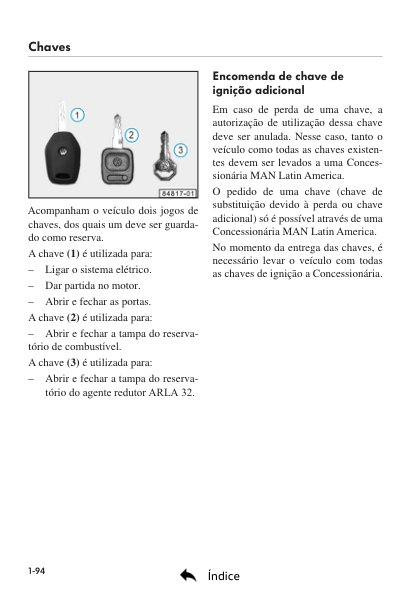

In [6]:
ds[3]["image"]

We can see that the dataset currently just contains images which map to a single page of a document. We can also see from the example document that the document does contain some visual elements which could be relevant for retrieval.

What we need to train or fine tune ColPali is at least one query for each of our the document images in our dataset.

## Using Qwen2-VL to generate queries

Whilst the original ColPali paper used the Claude 3.0 Sonnet model to generate queries for the UFO dataset, we'll use the Qwen2-VL model to generate queries for our UFO dataset. Specifcally we'll use the 7B variant of the model ([Qwen/Qwen2-VL-7B-Instruct](https://huggingface.co/Qwen/Qwen2-VL-7B-Instruct)). This is an open VLLM (Apache 2.0 licensed) Vision Language Model which has shown strong performance on a variety of vision and language tasks. Whilst the model won't run on a standard T4 Google Colab instance we can run the model either on a L4 or an A100 GPU on Google Colab or you can use the Hugging Face Jupyter Spaces [template](https://huggingface.co/spaces/SpacesExamples/jupyterlab?duplicate=true) to run the model on an L40s as I did.



To start let's load the model and get a sense of how we can use it. We'll do this through the Transformers library. It's also possible to run the model using the vLLM library but since we're only focusing on generating a relatively small number of queries this extra set up probably isn't worth it in this case (I'd be interested to hear in the comments if you try it out and how it goes).

To start we'll load the model. We'll use `flash_attention_2` which should help a bit with the performance and memory usage of the model.

In [ ]:
#from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
#from qwen_vl_utils import process_vision_info
#import torch

#model = Qwen2VLForConditionalGeneration.from_pretrained(
#    "Qwen/Qwen2-VL-7B-Instruct",
#    torch_dtype=torch.bfloat16,
#    attn_implementation="flash_attention_2",
#    device_map="auto",
#)

We next define the processor. This is the component that will help us prepare the inputs for the model.

In [ ]:
# default processer
#processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

## Using GPT-4 Model to generate queries


In [ ]:
from dotenv import load_dotenv
import openai

load_dotenv()
OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')

openai.api_key = OPENAI_API_KEY

image_path = "caminho/para/sua/imagem.jpg"

# Carregar a imagem
with open(image_path, "rb") as image_file:
    image_data = image_file.read()

# Enviar imagem para o GPT-4V
response = openai.ChatCompletion.create(
    model="gpt-4-vision",
    messages=[
        {"role": "system", "content": "Você é um assistente que analisa imagens e responde perguntas."},
        {"role": "user", "content": "O que você vê nesta imagem?"}
    ],
    files=[
        {"file": ("image.jpg", image_data)}
    ]
)

# Imprimir a resposta
print(response["choices"][0]["message"]["content"])


As with many more recent models, we can use a chat template to help us prepare the inputs for the model. Here is the example from the Qwen2-VL-7B-Instruct model card.

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

We can now pass this to the processor to get the inputs ready for the model. You'll see here we first pass in the messages to the `apply_chat_template` method of the processor and then use the `process_vision_info` helper function which comes from the `qwen_vl_utils` library to prepare images and videos (which are not relevant here).

In [ ]:
#text = processor.apply_chat_template(
#    messages, tokenize=False, add_generation_prompt=True
#)
#image_inputs, video_inputs = process_vision_info(messages)

If we take a look at the `text` we can see that the processor has applied a chat template to the messages.

In [ ]:
#text

We now pass the text, image and video inputs (in this case `None`) to the processor and prepare the inputs for the model.

In [ ]:
#inputs = processor(
#    text=[text],
#    images=image_inputs,
#    videos=video_inputs,
#    padding=True,
#    return_tensors="pt",
#)
#inputs = inputs.to("cuda")

we can see what this input looks like

In [ ]:
#inputs

Now the inputs are ready to pass to the model. BTW, all of this inference code is copied straight from the Qwen2-VL-7B-Instruct model card on Hugging Face. There are a few things we might want to tweak but the basic examples are pretty much all we need for our use case.

In [ ]:
generated_ids = model.generate(**inputs, max_new_tokens=200)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
output_text

## Building Colpali queries

We now have a sense of how to generate responses using both a text and image input using the Qwen2-VL-7B-Instruct model. We'll now use this model to generate queries for our UFO dataset. To start, let's see how the prompt from the paper looks. The only thing we modified from the original prompt was to ask for JSON output rather than dictionaries since this model seemed to work better with this approach in my (somewhat limited) testing.

```python
prompt = """
You are an assistant specialized in Multimodal RAG tasks.

The task is the following: given an image from a pdf page, you will have to generate questions that can be asked by a user to retrieve information from a large documentary corpus.

The question should be relevant to the page, and should not be too specific or too general. The question should be about the subject of the page, and the answer needs to be found in the page.

Remember that the question is asked by a user to get some information from a large documentary corpus that contains multimodal data. Generate a question that could be asked by a user without knowing the existence and the content of the corpus.

Generate as well the answer to the question, which should be found in the page. And the format of the answer should be a list of words answering the question.

Generate at most THREE pairs of questions and answers per page as JSON with the following format, answer ONLY using JSON, NOTHING ELSE:

{
    "questions": [
        {
            "question": "XXXXXX",
            "answer": ["YYYYYY"]
        },
        {
            "question": "XXXXXX",
            "answer": ["YYYYYY"]
        },
        {
            "question": "XXXXXX",
            "answer": ["YYYYYY"]
        }
    ]
}

where XXXXXX is the question and ['YYYYYY'] is the corresponding list of answers that could be as long as needed.

Note: If there are no questions to ask about the page, return an empty list. Focus on making relevant questions concerning the page.

Here is the page:
"""
```

We'll copy and paste all of the previous code to generate a response from the model for an example from our UFO dataset. We'll wrap this in a function once we've got a better sense of what we're looking for.

In [ ]:
messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": ds[0]["image"],
            },
            {"type": "text", "text": prompt},
        ],
    }
]

In [ ]:
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

In [ ]:
generated_ids = model.generate(**inputs, max_new_tokens=200)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
output_text

You'll see we get some responses like this `"What is the main event mentioned in the page?"` which is a bit too specific and tailored to the particular page. There are a few reasons this might be happening but the first thing we should play around with is changing the prompt.

### Validating the responses

One of the big challenges you can have in generating synthetic data at scale is ensuring that you get valid responses that you can use in downstream tasks for training without having to do a lot of manual verification. Let's see if we can load the response as valid JSON

In [ ]:
import json

In [ ]:
json.loads(output_text[0])

In [ ]:
print(output_text[0])

Having a valid JSON is a good start but in many synthetic data generation tasks, people are increasingly using Pydantic to ensure outputs are valid in other ways.
Let's take a look at a rewritten prompt I created for generating queries. In this prompt we ask the VLLM model to generate 3 different types of retrieval queries:

In [ ]:
prompt = """You are an AI assistant specialized in document retrieval tasks. Given an image of a document page, your task is to generate retrieval queries that someone might use to find this document in a large corpus.

Please generate 3 different types of retrieval queries:

1. A broad topical query: This should cover the main subject of the document.
2. A specific detail query: This should focus on a particular fact, figure, or point made in the document.
3. A visual element query: This should reference a chart, graph, image, or other visual component in the document, if present.

Important guidelines:
- Ensure the queries are relevant for retrieval tasks, not just describing the page content.
- Frame the queries as if someone is searching for this document, not asking questions about its content.
- Make the queries diverse and representative of different search strategies.

For each query, also provide a brief explanation of why this query would be effective in retrieving this document.

Format your response as a JSON object with the following structure:

{
  "broad_topical_query": "Your query here",
  "broad_topical_explanation": "Brief explanation",
  "specific_detail_query": "Your query here",
  "specific_detail_explanation": "Brief explanation",
  "visual_element_query": "Your query here",
  "visual_element_explanation": "Brief explanation"
}

If there are no relevant visual elements, replace the third query with another specific detail query.

Here is the document image to analyze:
<image>

Generate the queries based on this image and provide the response in the specified JSON format."""

We ask the model for JSON output, we can represent this using a simple Pydantic model.

In [ ]:
from pydantic import BaseModel
from typing import Tuple


class GeneralRetrievalQuery(BaseModel):
    broad_topical_query: str
    broad_topical_explanation: str
    specific_detail_query: str
    specific_detail_explanation: str
    visual_element_query: str
    visual_element_explanation: str

We could add additional constraints to our Pydantic model for example we could set a minimum and maximum length for the queries and answers. We'll get back to this at the end of the post but for now we can make a start with this simpler approach.

We'll now wrap this in a function to generate a response from the model using our Pydantic model.

## An update retrieval focused prompt

In [ ]:
def get_retrieval_prompt(prompt_name: str) -> Tuple[str, GeneralRetrievalQuery]:
    if prompt_name != "general":
        raise ValueError("Only 'general' prompt is available in this version")

    prompt = """You are an AI assistant specialized in document retrieval tasks. Given an image of a document page, your task is to generate retrieval queries that someone might use to find this document in a large corpus.

Please generate 3 different types of retrieval queries:

1. A broad topical query: This should cover the main subject of the document.
2. A specific detail query: This should focus on a particular fact, figure, or point made in the document.
3. A visual element query: This should reference a chart, graph, image, or other visual component in the document, if present.

Important guidelines:
- Ensure the queries are relevant for retrieval tasks, not just describing the page content.
- Frame the queries as if someone is searching for this document, not asking questions about its content.
- Make the queries diverse and representative of different search strategies.

For each query, also provide a brief explanation of why this query would be effective in retrieving this document.

Format your response as a JSON object with the following structure:

{
  "broad_topical_query": "Your query here",
  "broad_topical_explanation": "Brief explanation",
  "specific_detail_query": "Your query here",
  "specific_detail_explanation": "Brief explanation",
  "visual_element_query": "Your query here",
  "visual_element_explanation": "Brief explanation"
}

If there are no relevant visual elements, replace the third query with another specific detail query.

Here is the document image to analyze:
<image>

Generate the queries based on this image and provide the response in the specified JSON format."""

    return prompt, GeneralRetrievalQuery


# Example usage:
prompt_name = "general"
prompt, pydantic_model = get_retrieval_prompt(prompt_name)
print(f"Prompt for '{prompt_name}':")
print(prompt)
print(f"\nPydantic model for this prompt: {pydantic_model}")

We'll now also wrap this in a function to generate a response from the model using our Pydantic model. We could probably do a bit more refactoring here but this will do for now.

In [ ]:
def generate_response(prompt, image):
    messages = [
        {
            "role": "user",
            "content": [
                {
                    "type": "image",
                    "image": image,
                },
                {"type": "text", "text": prompt},
            ],
        }
    ]

    text = processor.apply_chat_template(
        messages, tokenize=False, add_generation_prompt=True
    )

    image_inputs, video_inputs = process_vision_info(messages)

    inputs = processor(
        text=[text],
        images=image_inputs,
        videos=video_inputs,
        padding=True,
        return_tensors="pt",
    )
    inputs = inputs.to("cuda")

    generated_ids = model.generate(**inputs, max_new_tokens=200)
    generated_ids_trimmed = [
        out_ids[len(in_ids) :]
        for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
    ]

    output_text = processor.batch_decode(
        generated_ids_trimmed,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False,
    )

    return output_text

Let's now generate a response from the model for an example image from our UFO dataset.

In [ ]:
generate_response(prompt, ds[2]["image"])

We can see the model is doing a reasonable job of generating queries.

```
['{\n  "broad_topical_query": "Document discussing the possibility of a cameraman going on the record in the future",\n  "broad_topical_explanation": "This query focuses on the main topic of the document, which is the discussion about the cameraman\'s potential to go on the record.",\n  "specific_detail_query": "Document mentioning Ray Santilli and his attempts to persuade the cameraman",\n  "specific_detail_explanation": "This query targets a specific detail in the document, which is Ray Santilli\'s efforts to contact the cameraman.",\n  "visual_element_query": "Document containing images of a damaged leg and an alien\'s foot",\n  "visual_element_explanation": "This query refers to the visual elements present in the document, which are images of a damaged leg and an alien\'s foot."\n}']
```


```{.tip}
One thing I have found in my experiments with generating synthetic data is that adding a request for an "explanation" from the model sometimes seems to help improve the quality of the generated data. I assume this is already noted somewhere in the literature (if not I'll call this `explain then generate`!). This seems to particularly helpful when generating more complex queries. Having the explanation can also give you a sense of how the model "understands" the task. This obviously comes with the donwside that it takes longer to generate the data and more tokens are required but it often seems worth trying.
```

## Generating the full dataset

As we play with the prompts and refine the queries we will often iterate quite quickly on a few examples. Once we're reasonably confident in the queries we can generate a larger dataset to see how well our prompts work across a larger set of examples.


In [ ]:
ds

In [ ]:
sample = ds.take(100)

To generate our full dataset we just wrap our previous code in a loop and run it for all the examples in our dataset. We add a very broad exception handler to catch any errors and continue with the next example. This is obviously not production code but it's good enough to get started with. If we scale to a much bigger dataset we might want to add some more robust error handling.

In [ ]:
from tqdm.auto import tqdm

responses = []
for row in tqdm(sample):
    try:
        resp = generate_response(prompt, row["image"])
        responses.append(resp)
    except Exception as e:
        responses.append(None)

In [ ]:
responses[0]

We can see how many errors we have in our dataset.

In [ ]:
len([r for r in responses if r is None])

No bad generations!

We can also look at the first response to see what it looks like.

In [ ]:
responses[0][0]

Let's see if we can parse this into a JSON object.

In [ ]:
json.loads(responses[0][0])

first example seems to work, now let's add this to our dataset and see how many we can parse.

In [ ]:
sample = sample.add_column("raw_queries", responses)

In [ ]:
sample

To deal with bad generations we'll create just fill out these column with `None` values. We can grab all the required keys from the valid first response.

In [ ]:
keys = list(json.loads(responses[0][0]).keys())
keys

and do something like this to fill out this row

In [ ]:
{k: None for k in keys}

We create a function to extract the data from the raw queries and parse them into a JSON object.

In [ ]:
def extract_data(row):
    try:
        data = json.loads(row["raw_queries"][0])
        data["parsed_into_json"] = True
        return data
    except Exception:
        data = {k: None for k in keys}
        data["parsed_into_json"] = False
        return data

We can now use the `map` method to apply this function to our dataset.

In [ ]:
parsed_ds = sample.map(extract_data)

We can then see how many we've successfully parsed.

In [ ]:
from collections import Counter

Counter(parsed_ds["parsed_into_json"])

So in this case 5% of the responses were not parseable. This isn't too bad and we might be able to live with this.

## Pushing to the Hub

We can now push this dataset to the Hugging Face Hub. This will also allow us to view the dataset in the Dataset Viewer. This can often be a very nice way of quickly checking through examples in a dataset to see how the quality looks.

If you are not authenticated you can use the `login` function to authenticate with the Hub.

In [ ]:
from huggingface_hub import login

In [ ]:
login()

In [ ]:
parsed_ds.push_to_hub("davanstrien/ufo-ColPali")

Here is what the dataset looks like in the Hugging Face Hub. You'll see there are actually more than a 100 examples since I did a larger generation of data since doing the first batch of a 100. You can be your own judge but my sense it that the queries are looking pretty good already.

<iframe
  src="https://huggingface.co/datasets/davanstrien/ufo-ColPali/embed/viewer/default/train"
  frameborder="0"
  width="100%"
  height="560px"
></iframe>

## Conclusion, improvements and next steps

There are a few improvements that we could make to this process.

### Structured Generation

One of the first things I think would be worth exploring further is using structured generation to improve the quality of the generated queries. This would allow us to properly use the Pydantic models to constrain the outputs. The `Outlines` library has functionality for doing this with for [VLMs](https://dottxt-ai.github.io/outlines/reference/models/transformers_vision/). Once I am more satisified with the quality of the queries I'll come back to this.

### More diverse queries

I focused on generating a single type of query for each example in the UFO dataset. I think for a dataset of this size it would be worth taking a more diverse set of generations. Below you can see an apendix with a few options for these kinds of queries.

### Next Steps

I am keen to test this approach with a few more domains and also work on the actual fine-tuning of ColPali models.


## Appendix more diverse queries

Here are a few more examples of prompts I am experimenting with.


In [ ]:
from pydantic import BaseModel
from typing import List, Optional, Tuple, Union

# Pydantic models for each prompt type


class GeneralRetrievalQuery(BaseModel):
    broad_topical_query: str
    broad_topical_explanation: str
    specific_detail_query: str
    specific_detail_explanation: str
    visual_element_query: str
    visual_element_explanation: str


class MultiDocumentComparisonQuery(BaseModel):
    comparison_query: str
    comparison_explanation: str
    corroboration_contradiction_query: str
    corroboration_contradiction_explanation: str


class DomainSpecificQuery(BaseModel):
    identified_domain: str
    domain_specific_query: str
    domain_specific_explanation: str
    data_findings_query: str
    data_findings_explanation: str
    applications_implications_query: str
    applications_implications_explanation: str


class VisualElementFocusQuery(BaseModel):
    similar_visual_element_query: str
    similar_visual_element_explanation: str
    text_visual_combination_query: str
    text_visual_combination_explanation: str
    visual_content_understanding_query: str
    visual_content_understanding_explanation: str


class TemporalMetadataQuery(BaseModel):
    temporal_query: str
    temporal_explanation: str
    topic_metadata_combination_query: str
    topic_metadata_combination_explanation: str
    update_related_document_query: str
    update_related_document_explanation: str


class DifficultyAmbiguityQuery(BaseModel):
    simple_query: str
    simple_explanation: str
    complex_query: str
    complex_explanation: str
    ambiguous_query: str
    ambiguous_explanation: str


class MultilingualMultimodalQuery(BaseModel):
    multilingual_query: str
    multilingual_explanation: str
    multimodal_combination_query: str
    multimodal_combination_explanation: str
    text_visual_understanding_query: str
    text_visual_understanding_explanation: str


def get_retrieval_prompt(
    prompt_name: str,
) -> Tuple[
    str,
    Union[
        GeneralRetrievalQuery,
        MultiDocumentComparisonQuery,
        DomainSpecificQuery,
        VisualElementFocusQuery,
        TemporalMetadataQuery,
        DifficultyAmbiguityQuery,
        MultilingualMultimodalQuery,
    ],
]:
    prompts = {
        "general": (
            """You are an AI assistant specialized in document retrieval tasks. Given an image of a document page, your task is to generate retrieval queries that someone might use to find this document in a large corpus.

Please generate 3 different types of retrieval queries:

1. A broad topical query: This should cover the main subject of the document.
2. A specific detail query: This should focus on a particular fact, figure, or point made in the document.
3. A visual element query: This should reference a chart, graph, image, or other visual component in the document, if present.

Important guidelines:
- Ensure the queries are relevant for retrieval tasks, not just describing the page content.
- Frame the queries as if someone is searching for this document, not asking questions about its content.
- Make the queries diverse and representative of different search strategies.

For each query, also provide a brief explanation of why this query would be effective in retrieving this document.

Format your response as a JSON object with the following structure:

{
  "broad_topical_query": "Your query here",
  "broad_topical_explanation": "Brief explanation",
  "specific_detail_query": "Your query here",
  "specific_detail_explanation": "Brief explanation",
  "visual_element_query": "Your query here",
  "visual_element_explanation": "Brief explanation"
}

If there are no relevant visual elements, replace the third query with another specific detail query.

Here is the document image to analyze:
<image>

Generate the queries based on this image and provide the response in the specified JSON format.""",
            GeneralRetrievalQuery,
        ),
        "comparison": (
            """Imagine this document page is part of a larger corpus. Your task is to generate retrieval queries that would require comparing this document with others in the corpus.

Please generate 2 retrieval queries:

1. A query comparing this document's topic with a related subject
2. A query seeking documents that contradict or support the main point of this page

For each query, provide a brief explanation of how it encourages document comparison and why it would be effective for retrieval.

Format your response as a JSON object with the following structure:

{
  "comparison_query": "Your query here",
  "comparison_explanation": "Brief explanation",
  "corroboration_contradiction_query": "Your query here",
  "corroboration_contradiction_explanation": "Brief explanation"
}

Here is the document image to analyze:
<image>

Generate the queries based on this image and provide the response in the specified JSON format.""",
            MultiDocumentComparisonQuery,
        ),
        "domain": (
            """Your task is to create retrieval queries that a professional in the document's domain might use to find this document in a large corpus.

First, identify the domain of the document (e.g., scientific, financial, legal, medical, technical).

Then, generate 3 retrieval queries:

1. A query using domain-specific terminology
2. A query seeking specific data or findings presented in the document
3. A query related to the document's potential applications or implications

For each query, provide a brief explanation of its relevance to the domain and why it would be effective for retrieval.

Format your response as a JSON object with the following structure:

{
  "identified_domain": "Domain name",
  "domain_specific_query": "Your query here",
  "domain_specific_explanation": "Brief explanation",
  "data_findings_query": "Your query here",
  "data_findings_explanation": "Brief explanation",
  "applications_implications_query": "Your query here",
  "applications_implications_explanation": "Brief explanation"
}

Here is the document image to analyze:
<image>

Generate the queries based on this image and provide the response in the specified JSON format.""",
            DomainSpecificQuery,
        ),
        "visual": (
            """Your task is to generate retrieval queries focusing on the visual elements in this document page (charts, tables, images, diagrams).

Please generate 3 retrieval queries:

1. A query specifically asking for documents with similar visual elements
2. A query combining textual and visual information
3. A query that would require understanding the content of the visual element to retrieve this document

For each query, provide a brief explanation of how it incorporates visual elements and why it would be effective for retrieval.

Format your response as a JSON object with the following structure:

{
  "similar_visual_element_query": "Your query here",
  "similar_visual_element_explanation": "Brief explanation",
  "text_visual_combination_query": "Your query here",
  "text_visual_combination_explanation": "Brief explanation",
  "visual_content_understanding_query": "Your query here",
  "visual_content_understanding_explanation": "Brief explanation"
}

If the document lacks significant visual elements, explain this and generate alternative queries focusing on the document's structure or layout.

Here is the document image to analyze:
<image>

Generate the queries based on this image and provide the response in the specified JSON format.""",
            VisualElementFocusQuery,
        ),
        "temporal": (
            """Assuming this document is part of a large, diverse corpus, your task is to generate retrieval queries that incorporate metadata or temporal aspects.

Please generate 3 retrieval queries:

1. A query specifying a likely time frame for this document
2. A query combining topical information with a metadata element (e.g., author, publication type)
3. A query seeking updated or related documents on the same topic

For each query, provide a brief explanation of how it uses temporal or metadata information and why it would be effective for retrieval.

Format your response as a JSON object with the following structure:

{
  "temporal_query": "Your query here",
  "temporal_explanation": "Brief explanation",
  "topic_metadata_combination_query": "Your query here",
  "topic_metadata_combination_explanation": "Brief explanation",
  "update_related_document_query": "Your query here",
  "update_related_document_explanation": "Brief explanation"
}

Here is the document image to analyze:
<image>

Generate the queries based on this image and provide the response in the specified JSON format.""",
            TemporalMetadataQuery,
        ),
        "difficulty": (
            """Your task is to create retrieval queries for this document at different levels of complexity and ambiguity.

Please generate 3 retrieval queries:

1. A simple, straightforward query
2. A complex query requiring understanding of multiple aspects of the document
3. An ambiguous query that could retrieve this document among others

For each query, provide a brief explanation of its complexity level or ambiguity and why it would be effective or challenging for retrieval.

Format your response as a JSON object with the following structure:

{
  "simple_query": "Your query here",
  "simple_explanation": "Brief explanation",
  "complex_query": "Your query here",
  "complex_explanation": "Brief explanation",
  "ambiguous_query": "Your query here",
  "ambiguous_explanation": "Brief explanation"
}

Here is the document image to analyze:
<image>

Generate the queries based on this image and provide the response in the specified JSON format.""",
            DifficultyAmbiguityQuery,
        ),
        "multilingual": (
            """Your task is to generate retrieval queries considering potential multilingual and multi-modal aspects of the document.

Please generate 3 retrieval queries:

1. A query in a different language (if applicable) that would retrieve this document
2. A query combining textual and non-textual elements
3. A query that requires understanding both the text and visual elements to retrieve this document accurately

For each query, provide a brief explanation of its multilingual or multi-modal nature and why it would be effective for retrieval.

Format your response as a JSON object with the following structure:

{
  "multilingual_query": "Your query here",
  "multilingual_explanation": "Brief explanation",
  "multimodal_combination_query": "Your query here",
  "multimodal_combination_explanation": "Brief explanation",
  "text_visual_understanding_query": "Your query here",
  "text_visual_understanding_explanation": "Brief explanation"
}

If the document is not suitable for multilingual queries, explain why and provide an alternative query.

Here is the document image to analyze:
<image>

Generate the queries based on this image and provide the response in the specified JSON format.""",
            MultilingualMultimodalQuery,
        ),
    }

    if prompt_name not in prompts:
        raise ValueError(
            f"Invalid prompt name. Choose from: {', '.join(prompts.keys())}"
        )

    return prompts[prompt_name]


# Example usage:
prompt_name = "general"  # You can change this to any of the available prompt names
prompt, pydantic_model = get_retrieval_prompt(prompt_name)
print(f"Prompt for '{prompt_name}':")
print(prompt)
print(f"\nPydantic model for this prompt: {pydantic_model}")